In [1]:
import pandas as pd

In [2]:
injected = pd.read_csv('injection_prediction.csv')
uninjected = pd.read_csv('no_injection_prediction.csv')

In [3]:
injected = injected.drop_duplicates()
uninjected = uninjected.drop_duplicates()

In [4]:
full = pd.concat([injected, uninjected], ignore_index = True)

In [5]:
full = full.drop_duplicates(subset = ['ci', 'intensity', 'type', 'localization'])

In [ ]:
# generating training heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.use("Agg")

req = full[full['anomaly'] == True]
req = req[['intensity', 'type', 'ci']]
req['intensity'] = req['intensity']/16
req['ci_category'] = req['ci'].round(decimals=3)
bins = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, float('inf')]
labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']
req['timeline'] = pd.cut(req['ci_category'], bins = bins, labels=labels).astype('string').fillna('T0')

req = req.drop(columns = ['ci', 'ci_category'])
req['timeline'] = pd.Categorical(req['timeline'], categories=['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10'], ordered=True)
heatmap_data = req.pivot_table(index='type', columns='timeline', values = 'intensity', aggfunc = 'mean')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot =True, cmap = 'coolwarm')
plt.xlabel('Intensity')
plt.ylabel('Type')
plt.savefig('eval_distribution.png')
plt.show()

In [6]:
#FPR and TPR
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('Agg')

In [ ]:
full['ground_truth'] = full['anomaly'] | full['localization']
fpr_anomaly, tpr_anomaly, _ = roc_curve(full['ground_truth'], full['anomaly'])
roc_auc_anomaly = auc(fpr_anomaly, tpr_anomaly)
fpr_localization, tpr_localization, _ = roc_curve(full['ground_truth'], full['localization'])
roc_auc_localization = auc(fpr_localization, tpr_localization)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_anomaly, tpr_anomaly, color='darkorange', lw=2, label='Anomaly ROC curve (area = {:.2f})'.format(roc_auc_anomaly))
plt.plot(fpr_localization, tpr_localization, color='navy', lw=2, label='Localization ROC curve (area = {:.2f})'.format(roc_auc_localization))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('TPR vs FPR.png')
plt.show()

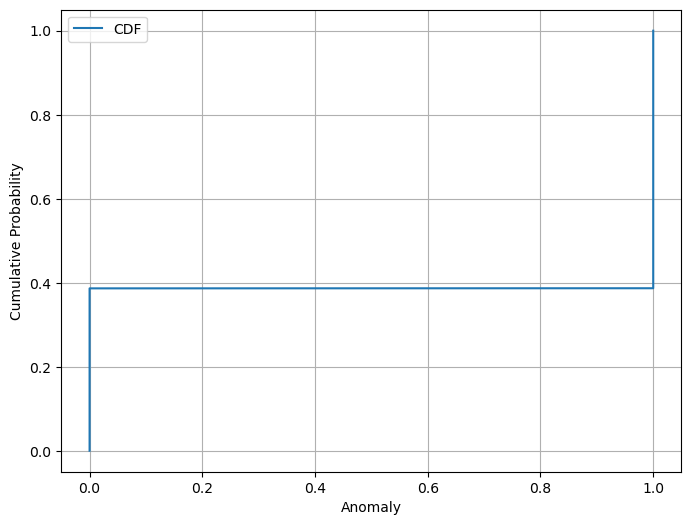

In [10]:
#CDF
import numpy as np
df_sorted = full.sort_values(by='anomaly')

# Calculate the CDF
total_points = len(df_sorted)
cdf = np.arange(1, total_points + 1) / total_points

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(df_sorted['anomaly'], cdf, label='CDF')
plt.xlabel('Anomaly')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.savefig('CDF.png')
plt.show()